In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import os
import json
import h5py
import sys
import pdb
import argparse
from sklearn.metrics import confusion_matrix
from scipy.stats import norm
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import seaborn as sns

# %pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

mu,sigma = -1, 1
TRAIN_ITERS = 15000
N = 200 # minibatch size

In [2]:
def my_mlp(inp, hidden_sizes):
    last_layer, last_shape = inp, inp.get_shape()[1]
    weights, biases, fc_layers = [], [], []
    for i, size in enumerate(hidden_sizes):
        w = tf.get_variable('w'+str(i),
                            [last_shape, size],
                            initializer=tf.random_normal_initializer())
        b = tf.get_variable('b'+str(i),
                            [size],
                            initializer=tf.constant_initializer(0.0))
        layer = tf.nn.tanh(tf.matmul(last_layer, w) + b)
        
        weights.append(w)
        biases.append(b)
        fc_layers.append(layer)
        last_layer, last_shape = layer, size
        
    return weights, biases, fc_layers

# MLP - used for D_pre, D1, D2, G networks
def mlp(input, output_dim):
    # construct learnable parameters within local scope
    w1=tf.get_variable("w0", [input.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b1=tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w2=tf.get_variable("w1", [6, 5], initializer=tf.random_normal_initializer())
    b2=tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w3=tf.get_variable("w2", [5,output_dim], initializer=tf.random_normal_initializer())
    b3=tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer(0.0))
    # nn operators
    fc1=tf.nn.tanh(tf.matmul(input,w1)+b1)
    fc2=tf.nn.tanh(tf.matmul(fc1,w2)+b2)
    fc3=tf.nn.tanh(tf.matmul(fc2,w3)+b3)
    return fc3, [w1,b1,w2,b2,w3,b3]
 

In [3]:
# TODO(Mohit): Not sure if this is needed, let's try with ADAM initially and see
# what we get. 
# re-used for optimizing all networks
def momentum_optimizer(loss,var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,                # Base learning rate.
        batch,  # Current index into the dataset.
        TRAIN_ITERS // 4,          # Decay step - this decays 4 times throughout training process.
        0.95,                # Decay rate.
        staircase=True)
    #optimizer=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=batch,var_list=var_list)
    optimizer=tf.train.MomentumOptimizer(learning_rate,0.6).minimize(loss,global_step=batch,var_list=var_list)
    return optimizer



#### Pre-train using MSE loss.

In [4]:
with tf.variable_scope('D_pre'):
    d_input_pl = tf.placeholder(tf.float32, shape=(N, 1), name='input_pl')
    d_label_pl = tf.placeholder(tf.float32, shape=(N, 1), name='labels_pl')
    d_weights, d_biases, d_fc_layers = my_mlp(d_input_pl, [11, 7, 1])
    d_network = d_fc_layers[-1]
    loss = tf.reduce_mean(tf.square(d_network - d_label_pl))
    

In [5]:
optimizer = momentum_optimizer(loss, None)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [6]:
# plot decision surface
def plot_d0(D, input_node):
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')
    # decision boundary
    
    r=1000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in a minibatch
    for i in range(r / N):
        x = np.reshape(xs[N * i:N * (i + 1)], (N, 1))
        ds[N * i: N * (i + 1)] = sess.run(D, {d_input_pl: x})

    ax.plot(xs, ds, label='decision boundary')
    ax.set_ylim(0,1.1)
    plt.legend()


##### Plot the decision surface without any training. This is a random decision surface

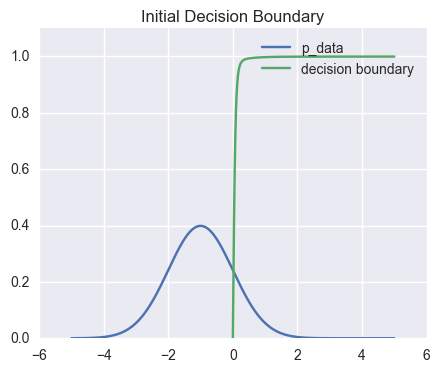

In [7]:
plot_d0(d_network, d_input_pl)
plt.title('Initial Decision Boundary')

##### Pretrain the network using MSE loss as described in the tutorial.

In [8]:
lh=np.zeros(1000)
for i in range(1000):
    #d=np.random.normal(mu,sigma,M)
    d=(np.random.random(N)-0.5) * 10.0 # instead of sampling only from gaussian, want the domain to be covered as uniformly as possible
    labels=norm.pdf(d,loc=mu,scale=sigma)
    lh[i],_=sess.run([loss,optimizer],
                     {
                         d_input_pl: np.reshape(d, (N,1)),
                         d_label_pl: np.reshape(labels, (N,1))
                     })


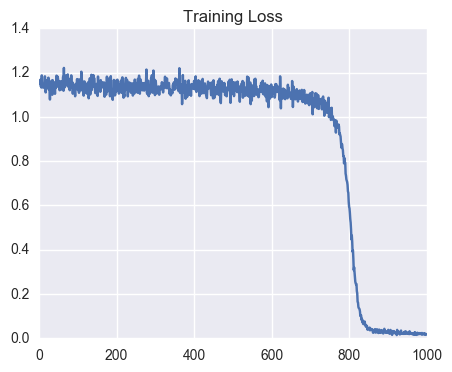

In [9]:
# training loss
plt.plot(lh)
plt.title('Training Loss')

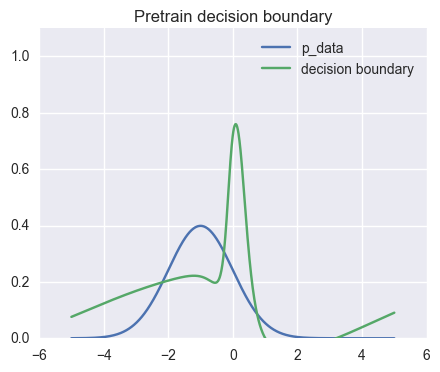

In [10]:
plot_d0(d_network, d_input_pl)
plt.title('Pretrain decision boundary')

In [11]:
# copy the learned weights over into a tmp array
v = sess.run([d_weights, d_biases])
d_pretrain_weights, d_pretrain_biases = v[0], v[1]
sess.close()

#### Now train the actual GAN

In [12]:
# Generator
with tf.variable_scope('G') as g_scope:
    g_input_pl = tf.placeholder(tf.float32, shape=(N, 1), name='G_input_pl')
    g_weights, g_biases, g_fc_layers = my_mlp(g_input_pl, [11, 7, 1])
    g_network = g_fc_layers[-1]
    # Scale the network output to [-5, 5]
    g_network = tf.multiply(5.0, g_network)
    
# Discriminator
with tf.variable_scope('D') as scope:
    d1_input_pl = tf.placeholder(tf.float32, shape=(N, 1), name='D_input_pl')
    d1_weights, d1_biases, d1_fc_layers = my_mlp(d1_input_pl, [11, 7, 1])
    d1_network = d1_fc_layers[-1]
    d1_output = tf.maximum(0.01, tf.minimum(0.99, d1_network))
    
    scope.reuse_variables()
    
    # Now define D2 that is used for Generator's input
    d2_weights, d2_biases, d2_fc_layers = my_mlp(g_network, [11, 7, 1])
    d2_network = d2_fc_layers[-1]
    d2_output = tf.maximum(0.01, tf.minimum(0.99, d2_network))

d_obj = tf.reduce_mean(tf.log(d1_output) + tf.log(1.0-d2_output)) # Maximize
g_obj = tf.reduce_mean(tf.log(d2_output)) # Maximize

d_opt = momentum_optimizer(1.0 - d_obj, d2_weights + d2_biases)
g_opt = momentum_optimizer(1.0 - g_obj, g_weights + g_biases)

In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

#### Copy the pretrained weights to the discriminator

In [14]:
for i, v in enumerate(d2_weights):
    sess.run(v.assign(d_pretrain_weights[i]))
for i, v in enumerate(d2_biases):
    sess.run(v.assign(d_pretrain_biases[i]))

In [15]:
def plot_fig():
    # plots pg, pdata, decision boundary 
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')

    # decision boundary
    r=5000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in same minibatch
    for i in range(r/N):
        x=np.reshape(xs[N*i:N*(i+1)],(N,1))
        ds[N*i:N*(i+1)]=sess.run(d1_output, {d1_input_pl: x})

    ax.plot(xs, ds, label='decision boundary')

    # distribution of inverse-mapped points
    zs=np.linspace(-5,5,r)
    gs=np.zeros((r,1)) # generator function
    for i in range(r/N):
        z=np.reshape(zs[N*i:N*(i+1)],(N,1))
        gs[N*i:N*(i+1)]=sess.run(g_network, {g_input_pl: z})
    histc, edges = np.histogram(gs, bins = 10)
    ax.plot(np.linspace(-5,5,10), histc/float(r), label='p_g')

    # ylim, legend
    ax.set_ylim(0,1.1)
    plt.legend()


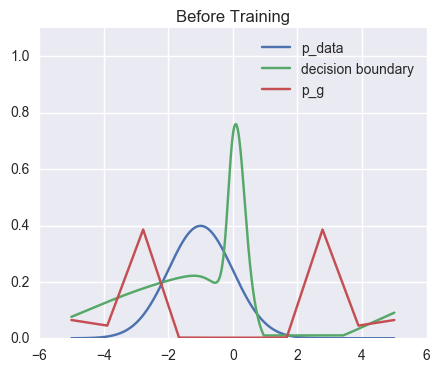

In [16]:
plot_fig()
plt.title('Before Training')

#### Train the GAN

In [17]:
k=1
histd, histg= np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
for i in range(TRAIN_ITERS):
    for j in range(k):
        x= np.random.normal(mu, sigma, N) # sampled m-batch from p_data
        x.sort()
        # sample m-batch from noise prior
        z= np.linspace(-5.0, 5.0, N) + np.random.random(N)*0.01
        histd[i], _ = sess.run([d_obj, d_opt],
                               {
                                   d1_input_pl: np.reshape(x, (N, 1)),
                                   g_input_pl: np.reshape(z, (N, 1))
                               })
    z = np.linspace(-5.0, 5.0,N) + np.random.random(N)*0.01 # sample noise prior
    histg[i], _ = sess.run([g_obj, g_opt], {g_input_pl: np.reshape(z, (N, 1))}) # update generator
    
    if i % (TRAIN_ITERS//10) == 0:
        print(float(i)/float(TRAIN_ITERS))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


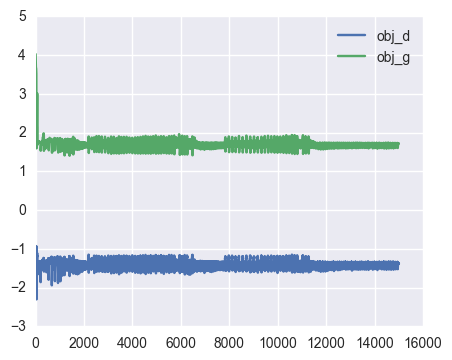

In [18]:
plt.plot(range(TRAIN_ITERS), histd, label='obj_d')
plt.plot(range(TRAIN_ITERS), 1-histg, label='obj_g')
plt.legend()

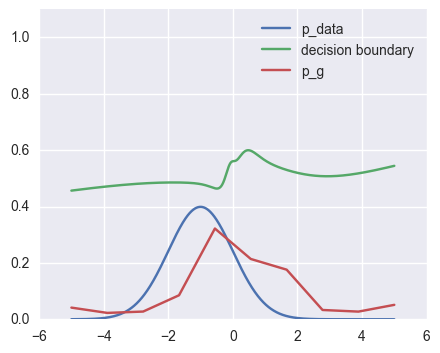

In [19]:
# Plot final results
plot_fig()